### Pull in bottom currents for one year, remove clipping, and save to pickle file
- Downloaded directly from OOI database using URL query

In [1]:
import os
import pickle
import glob
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

import numpy as np
import obspy
from obspy.clients.fdsn.client import Client 

import obspy

import pandas as pd
import scipy.ndimage
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kde
import requests

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Arial"]

In [12]:
# Load bottom currents using URL query from OOI databaset
# Note that the time window is specified within the URL

#HYSB1:
hysb1_url = "http://erddap.dataexplorer.oceanobservatories.org/erddap/tabledap/ooi-rs01slbs-mj01a-12-vel3db101.json?time%2Ceastward_sea_water_velocity%2Cnorthward_sea_water_velocity%2Cupward_sea_water_velocity&time%3E=2015-01-01T08%3A00%3A00Z&time%3C=2024-01-01T08%3A01%3A00Z"
#HYS14:
hys14_url = "http://erddap.dataexplorer.oceanobservatories.org/erddap/tabledap/ooi-rs01sum1-lj01b-12-vel3db104.json?time%2Ceastward_sea_water_velocity%2Cnorthward_sea_water_velocity%2Cupward_sea_water_velocity&time%3E=2015-01-01&time%3C=2024-01-01"

In [4]:
hysb1_response = requests.request("GET", hysb1_url)#, data=payload, headers=headers)
hys14_response = requests.request("GET", hys14_url)

In [5]:
hysb1_table = hysb1_response.json()
hys14_table = hys14_response.json()

In [6]:
def extract_raw_data(table):
    """
    Table is the .json table retrieved from the URL
    Median window is the amount of time in seconds over which to take the median of the absolute of the data
    """
    
    bc_times = []
    bc_ev = []
    bc_uv = []
    bc_nv = []
    bc_horz = []
    for ind,row in enumerate(table['table']['rows']):
        bc_times.append(datetime.datetime.strptime(row[0],'%Y-%m-%dT%H:%M:%SZ'))
        east = row[1]
        north = row[2]
        
        # Combine north and east to get overall horizontal velocity
        horz = np.sqrt((east**2)+(north**2))
        
        bc_horz.append(horz)
        bc_uv.append(row[3])
                            
        
    return bc_times,bc_horz,bc_uv

In [7]:
sb_times,sb_horz,sb_uv = extract_raw_data(hysb1_table)
hr_times,hr_horz,hr_uv = extract_raw_data(hys14_table)

In [8]:
# Remove clipping!

high = [i for i,e in enumerate(sb_horz) if e>0.5]
for i in high:
    sb_horz[i]=np.nan
high = [i for i,e in enumerate(hr_horz) if e>0.5]
for i in high:
    hr_horz[i]=np.nan

In [9]:
sb_times = [obspy.UTCDateTime(t) for t in sb_times]
hr_times = [obspy.UTCDateTime(t) for t in hr_times]

## Get hourly maximum and median horizontal bottom current speeds

In [13]:
sb_current_max = []
sb_current_med = []
sb_current_times = []
start_ind = 0
for i,t in enumerate(sb_times):
    
    if t.datetime.minute == 0:
        if t - sb_times[start_ind] == 3600:
            data = sb_horz[start_ind:i]
            sb_current_times.append(sb_times[start_ind])
            sb_current_med.append(np.nanmedian(data))
            sb_current_max.append(np.nanmax(data))
            start_ind = i
        else:
            start_ind = i

/var/folders/k7/tk8jpcf12gdbjj0htp_vqbtc0000gn/T/ipykernel_99691/2608058860.py:12: RuntimeWarning: All-NaN axis encountered
  sb_current_max.append(np.nanmax(data))


In [11]:
hr_current_max = []
hr_current_med = []
hr_current_times = []
start_ind = 0
for i,t in enumerate(hr_times):
    
    if t.datetime.minute == 0:
        if t - hr_times[start_ind] == 3600:
            data = hr_horz[start_ind:i]
            hr_current_times.append(hr_times[start_ind])
            hr_current_med.append(np.nanmedian(data))
            hr_current_max.append(np.nanmax(data))
            start_ind = i
        else:
            start_ind = i

/var/folders/k7/tk8jpcf12gdbjj0htp_vqbtc0000gn/T/ipykernel_99691/2425166389.py:12: RuntimeWarning: All-NaN axis encountered
  hr_current_max.append(np.nanmax(data))


Text(0.5, 1.0, 'HYS14 - Horizontal bottom current speeds')

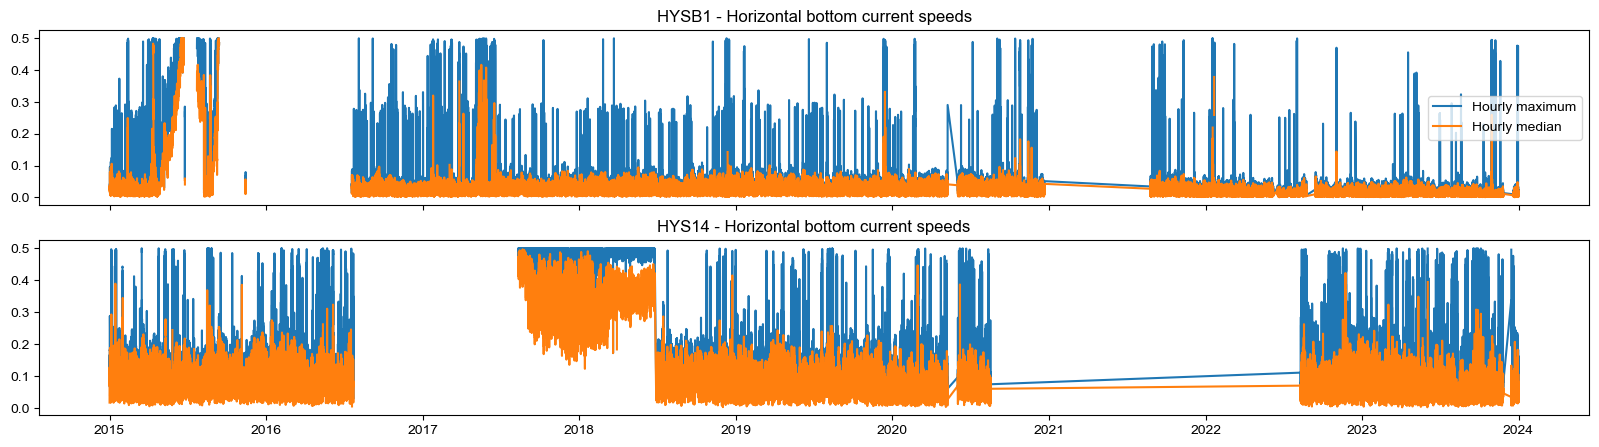

In [14]:
# Plot to make sure all looks good

fig, ax = plt.subplots(2,figsize=(20,5),sharex=True)
ax[0].plot([t.datetime for t in sb_current_times],sb_current_max,label='Hourly maximum')
ax[0].plot([t.datetime for t in sb_current_times],sb_current_med,label='Hourly median')
ax[0].legend()
ax[0].set_title('HYSB1 - Horizontal bottom current speeds')

ax[1].plot([t.datetime for t in hr_current_times],hr_current_max,label='Hourly maximum')
ax[1].plot([t.datetime for t in hr_current_times],hr_current_med,label='Hourly median')
# ax[1].legend()
ax[1].set_title('HYS14 - Horizontal bottom current speeds')

## Pickle!

In [65]:
with open('hysb1_bottomcurrents.pickle', 'wb') as handle:
    pickle.dump([sb_current_times,sb_current_max,sb_current_med],handle)

with open('hys14_bottomcurrents.pickle', 'wb') as handle:
    pickle.dump([hr_current_times,hr_current_max,hr_current_med],handle)